In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
import nltk
import pymorphy2
from nltk.stem import *
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from func.auto import autoTable
import func.cls as cls
from sklearn.decomposition import PCA

# Бинарная классификация

### Предобработка данных

In [10]:
# В прошлый раз 2:12 минуты длилось выполнение ячейки
data2 = cls.read_data_xlsx("data_2cls.xlsx")     # пропущенные значения удалены
title2 = cls.lemmatize_rus(list(data2["name"]))     # Названия
keywords2 = cls.lemmatize_rus(list(data2["keywords"]))   # ключевые слова
annotation2 = cls.lemmatize_rus(list(data2["annotation"]))   # аннотации
united_signs2 = [title2[i] + " " + keywords2[i] + " " + annotation2[i] for i in range(len(title2))]  # Объединенные признаковые пространства
labels2 = [eval(data2['classification_labels'][i])[0]['flag'] for i in range(len(data2['classification_labels']))]
stop_words = stopwords.words('english') + stopwords.words('russian')

## Визуализация

In [11]:
num_labels2 = [None]*len(labels2)
list_labels = list(set(labels2))     # порядок не совпадает
list_labels.sort()
for i in range(len(list_labels)):
    num = np.where(np.array(labels2) == list_labels[i])
    for j in num[0]:
        num_labels2[j] = i

In [112]:
tf_idf2 = TfidfVectorizer(max_features=None, stop_words=stop_words).fit_transform(united_signs2).toarray()

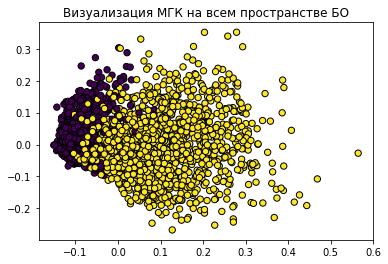

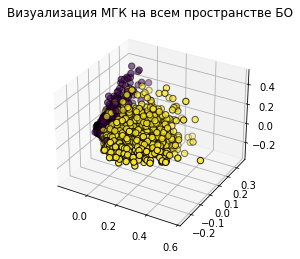

In [114]:
united_signs2_pca = cls.pca(tf_idf2, labels2, title='Визуализация МГК на всем пространстве БО')

## Классификация

In [107]:
title2_tf_idf = TfidfVectorizer(max_features=None, stop_words=stop_words).fit_transform(title2).toarray()
keywords2_tf_idf = TfidfVectorizer(max_features=None, stop_words=stop_words).fit_transform(keywords2).toarray()
annotation2_tf_idf = TfidfVectorizer(max_features=None, stop_words=stop_words).fit_transform(annotation2).toarray()
united_signs2_tf_idf = TfidfVectorizer(max_features=None, stop_words=stop_words).fit_transform(united_signs2).toarray()

In [110]:
print(title2_tf_idf.shape)
print(keywords2_tf_idf.shape)
print(annotation2_tf_idf.shape)
print(united_signs2_tf_idf.shape)

(3267, 6394)
(3267, 12186)
(3267, 19926)
(3267, 25124)


In [94]:
x_train, x_test, y_train, y_test = train_test_split(annotation2_tf_idf, labels2, train_size=0.3, random_state=0)

### Первый этап

In [95]:
parameters = {
    'penalty': ('l1', 'l2', 'elasticnet', None),
    'C': (1, 50, 100, 500, 1000),
    'max_iter': (80, 100, 200, 500),
    'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    'class_weight': ('balanced', None),
    'multi_class': ('multinomial', 'ovr')
}

In [96]:
param = {}
for key in list(parameters.keys()):
    print(key)
    param.update({key: parameters[key]})
    clf = LogisticRegression(random_state=0)
    prediction, classificationReport, best_params = cls.classifier(x_train, x_test, y_train, y_test, clf, param)
    param = best_params
    for key in list(param.keys()):
        param.update({key: (param[key],)})

penalty


c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError

C
max_iter
solver


c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


class_weight


c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


multi_class


c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [97]:
print(classificationReport)
best_params

              precision    recall  f1-score   support

       False       0.89      0.96      0.93      1228
        True       0.95      0.87      0.91      1059

    accuracy                           0.92      2287
   macro avg       0.92      0.91      0.92      2287
weighted avg       0.92      0.92      0.92      2287



{'C': (500,),
 'class_weight': ('balanced',),
 'max_iter': (80,),
 'multi_class': ('ovr',),
 'penalty': ('l2',),
 'solver': ('saga',)}

### Этап донастройки

In [92]:
param = {'C': (50,),
        'class_weight': ('balanced',),
        'max_iter': (15,30, 50, 80),
        'multi_class': ('multinomial',),
        'penalty': ('l2',),
        'solver': ('newton-cg',)}
clf = LogisticRegression(random_state=0)
prediction, classificationReport, best_params = cls.classifier(x_train, x_test, y_train, y_test, clf, param)
print(classificationReport)
best_params

              precision    recall  f1-score   support

       False       0.95      0.99      0.97      1228
        True       0.98      0.94      0.96      1059

    accuracy                           0.96      2287
   macro avg       0.96      0.96      0.96      2287
weighted avg       0.96      0.96      0.96      2287



{'C': 50,
 'class_weight': 'balanced',
 'max_iter': 15,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [93]:
autoTable(classificationReport, path='output/keywords2 logReg.docx')

### Не сокращенное признаковое пространство

In [15]:
parameters = {
    'penalty': ('l1', 'l2'),
    # 'C': (50, 100, 150),
    # 'max_iter': (100, 200, 500),
    # 'solver': ("liblinear",),
    # 'class_weight': (None)
}
clf = LogisticRegression(random_state=0)
prediction, classificationReport, best_params = classifier(x_train_N, x_test_N, y_train_N, y_test_N, clf, parameters)

ValueError: X has 8819 features, but KNeighborsClassifier is expecting 19469 features as input.

In [10]:
autoTable(classificationReport, path='output/clsRep logreg annotation.docx')

In [9]:
print(classificationReport)
best_params

              precision    recall  f1-score   support

       False       0.83      0.98      0.90      1262
        True       0.98      0.77      0.86      1084

    accuracy                           0.88      2346
   macro avg       0.90      0.87      0.88      2346
weighted avg       0.90      0.88      0.88      2346



{'solver': 'liblinear'}

In [ ]:
parameters = {
    # 'penalty': ('l2'),
    'C': (100,),# 200, 300),
    #'max_iter': (100, 200, 500),
    'solver': ("newton-cg", "lbfgs", "liblinear", "sag", "saga"),
    # 'class_weight': (None)
}

### Сокращенное признаковое пространство

In [12]:
# Получение сокращенных матриц без файлов
df_name_tf_idf_short = drf.dimensionality_reduction_func(name_tf_idf)
df_annotation_tf_idf_short = drf.dimensionality_reduction_func(annotation_tf_idf)
name_tf_idf_short, terms_by_name = drf.df_to_list(df_name_tf_idf_short)
annotation_tf_idf_short, terms_by_annotation = drf.df_to_list(df_annotation_tf_idf_short)

In [5]:
# Считывание annotation_tf_idf_short из файла
name_tf_idf_short_FromFile = []
file = open("name_tf_idf_short.txt", 'r', encoding='utf-8')
for line in file:
    name_tf_idf_short_FromFile.append(eval(line))
file.close()
# Считывание annotation_tf_idf_short из файла
annotation_tf_idf_short_FromFile = []
file = open("annotation_tf_idf_short.txt", 'r', encoding='utf-8')
for line in file:
    annotation_tf_idf_short_FromFile.append(eval(line))
file.close()

In [6]:
x_train_Ns, x_test_Ns, y_train_Ns, y_test_Ns = train_test_split(name_tf_idf_short_FromFile, labels, train_size=0.3, random_state=0)
x_train_As, x_test_As, y_train_As, y_test_As = train_test_split(annotation_tf_idf_short_FromFile, labels, train_size=0.3, random_state=0)

In [36]:
parameters = {
    'n_estimators': (400,),
    'criterion': ('gini',),
    'oob_score': (True,),
    'bootstrap': (True,),
    'max_depth': (200,),
    'min_samples_split': (2,),
    'min_samples_leaf':  (1,),
    'max_features': (0.3, 0.5, 50, "sqrt", "log2", None),
    'random_state': (0,)
}

clf = RandomForestClassifier()
prediction, classificationReport, best_params = classifier(x_train_Ns, x_test_Ns, y_train_Ns, y_test_Ns, clf, parameters)

In [37]:
print(classificationReport)
best_params

              precision    recall  f1-score   support

       False       0.82      0.96      0.88      1262
        True       0.94      0.75      0.84      1084

    accuracy                           0.87      2346
   macro avg       0.88      0.86      0.86      2346
weighted avg       0.88      0.87      0.86      2346



{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 200,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400,
 'oob_score': True,
 'random_state': 0}

In [48]:
autoTable(classificationReport, path='output/clsRep RF short annotation.docx')

In [44]:
table_bin = pd.read_excel('Таблица метрик бинарной классификации.xlsx', index_col=0)

In [64]:
list(table_bin.index)

['Логистическая регрессия', 'КБС', 'Дерево решений', 'Случайный лес']

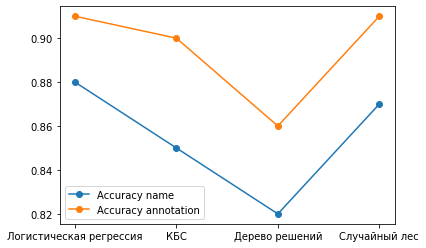

In [67]:
plt.figure()
plt.plot(list(table_bin.index), list(table_bin['Accuracy name']), marker='o', label='Accuracy name')
plt.plot(list(table_bin.index), list(table_bin['Accuracy annotation']), marker='o', label='Accuracy annotation')
plt.legend()

# Многоклассовая классификация

In [10]:
from func.cls import *

In [62]:
data10 = cls.read_data_xlsx("data_10cls.xlsx")
print(data10.columns)
title = list(data10["title"])     # Названия
tags_names = list(data10["tags_names"])   # ключевые слова
abstract = list(data10["abstract"])   # аннотации
# Убираем пропуски значений в tags_names, были nan, в других признаквых пространствах пропусков не обнаружено
tags_names = list(np.where(np.array(tags_names) == 'nan', '', tags_names))
united_signs = [title[i] + " " + tags_names[i] + " " + abstract[i] for i in range(len(title))]  # Объединенные признаковые пространства
markers = list(data10["marker"])

AttributeError: module 'func.cls' has no attribute 'read_data_xlsx'

In [54]:
_lemmatizer = WordNetLemmatizer()    # для английского текста
def lemmatize(texts):
    """Функция лемматизации для списка текстов
    text - исходный текст
    res - список лемматизированных текстов
    """
    res = list()
    for text in texts:
        text = text.lower()
        nltk_tokens = word_tokenize(text) # разбиваем текст на слова
        line = ''
        for word in nltk_tokens:
            #parse = _morph.parse(word)[0]  # Это было для русских слов
            # дальше обрабатываем все части речи
            lemm_word = _lemmatizer.lemmatize(word, pos='n')
            lemm_word = _lemmatizer.lemmatize(lemm_word, pos='v')
            lemm_word = _lemmatizer.lemmatize(lemm_word, pos='r')
            lemm_word = _lemmatizer.lemmatize(lemm_word, pos='a')
            lemm_word = _lemmatizer.lemmatize(lemm_word, pos='s')
            line += ' ' + lemm_word
        res.append(line) # lemmatize для английских слов
    return res

In [55]:
title[1]

'Demystifying Quantum Blockchain for Healthcare'

In [56]:
lemmatize(title)

[' zkbridge : trustless cross-chain bridge make practical',
 ' demystify quantum blockchain for healthcare',
 ' current injection and voltage insertion attack against the vmg-kljn secure key exchanger',
 ' combo : pre-training representation of binary code use contrastive learn',
 ' spatial name system',
 ' privacy of federate qr decomposition use additive secure multiparty computation',
 ' dres-fl : dropout-resilient secure federate learn for non-iid client via secret data share',
 ' artificial replay : a meta-algorithm for harness historical data in bandit',
 ' bicoptor : two-round secure three-party non-linear computation without preprocessing for privacy-preserving machine learn',
 ' post-quantum zero-knowledge with space-bounded simulation',
 ' model-driven engineer for formal verification and security test of authentication protocol',
 ' pmpl : a robust multi-party learn framework with a privilege party',
 ' hide image in deep probabilistic model',
 ' security and privacy concern

### Визуализация

In [6]:
num_markers = [0]
i = 0
for j in range(1, len(markers)):
    if markers[j] == markers[j-1]:
        num_markers.append(i)
    else:
        i+=1
        num_markers.append(i)

In [32]:
from sklearn.manifold import TSNE

def tsne(data, target, n_components=2, perplexity=30, learning_rate='auto', n_iter=1000, metric='euclidean', init='random', early_exaggeration=12.0):

    # Применение t-SNE для визуализации данных в двух измерениях
    tsne_ = TSNE(n_components=n_components, perplexity=perplexity, early_exaggeration=early_exaggeration,
                 learning_rate=learning_rate, n_iter=n_iter, metric=metric, init=init
                 )
    X_tsne = tsne_.fit_transform(data)

    # Визуализация результата
    if n_components == 2:
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=target,
                    # cmap=mcolors.ListedColormap(["red", "gray"]),
                    edgecolor="k",
                    s=40)
    if n_components == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=target,
                    # cmap=mcolors.ListedColormap(["red", "gray"]),
                    edgecolor="k",
                    s=40)
    plt.show()

In [35]:
vect = CountVectorizer(stop_words='english')
count = vect.fit_transform(abstract)
matrix = count.toarray()

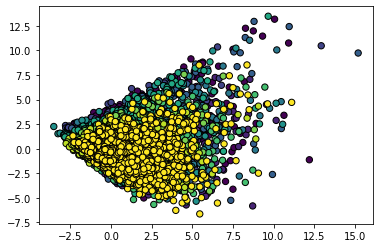

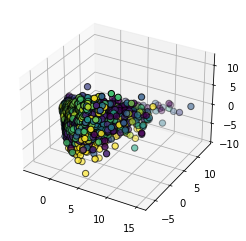

In [36]:
pca(matrix, num_markers)

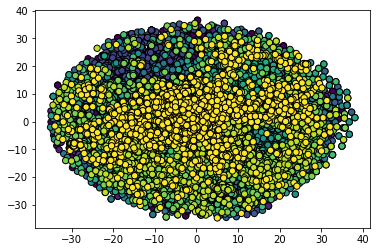

In [39]:
tsne(matrix, num_markers)

### Классификация

In [6]:
x_train, x_test, y_train, y_test = train_test_split(united_signs, markers, train_size=0.3, random_state=0)

In [13]:
parameters = {
    'n_estimators': (1200, 1500, 2000),
    'criterion': ('gini',),
    'oob_score': (False,),
    'bootstrap': (False,),
    'max_depth': (150,),
    'min_samples_split': (2,),
    'min_samples_leaf':  (1,),
    'max_features': (0.1,),
}

key_param = {}

for key in parameters.keys():
    key_param.update({'clf__'+key: parameters[key]})

clf = RandomForestClassifier(random_state=0)
prediction, classificationReport, best_params = multiclassifier(x_train, x_test, y_train, y_test, clf, key_param)

In [14]:
print(classificationReport)
best_params

                       precision    recall  f1-score   support

      computer vision       0.89      0.92      0.90      1245
      control systems       0.91      0.77      0.83      1031
       cyber security       0.90      0.96      0.93      2015
             database       0.91      0.92      0.91      1330
               expert       0.93      0.94      0.93      1332
                fuzzy       0.98      0.98      0.98      1232
information retrieval       0.86      0.84      0.85      1398
          neural nets       0.92      0.85      0.88      1313
              robotic       0.87      0.91      0.89      1068
          text mining       0.90      0.94      0.92      1355

             accuracy                           0.91     13319
            macro avg       0.91      0.90      0.90     13319
         weighted avg       0.91      0.91      0.91     13319



{'clf__bootstrap': False,
 'clf__criterion': 'gini',
 'clf__max_depth': 150,
 'clf__max_features': 0.1,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__n_estimators': 1500,
 'clf__oob_score': False}

In [36]:
autoTable(classificationReport, path='output/clsRep RF united_signs10.docx')

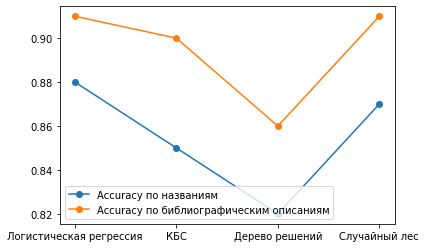

In [26]:
table_bin = pd.read_excel('Таблица метрик бинарной классификации.xlsx', index_col=0)
list(table_bin.index)
plt.figure()
plt.plot(list(table_bin.index), list(table_bin['Accuracy name']), marker='o', label='Accuracy по названиям')
plt.plot(list(table_bin.index), list(table_bin['Accuracy annotation']), marker='o', label='Accuracy по библиографическим описаниям')
plt.legend()